In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange 
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import sys
import time
import numpy as np
import imageio
import torchvision
import torchinfo


In [2]:
from models_utils import *

In [3]:
H = 160
W = 192

imgs_all,labels_all,labels2_all = create_dataset()


/opt/tljh/user/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [4]:
annotations = []
annotations2 = []
meshs = []
for ix in range(1,6):
    for j in range(1,3):
        img = torch.from_numpy(imageio.imread('CLUST_png/ETH-0'+str(ix)+'-'+str(j)+'/Data/00001.png')).float()
        annotation = torch.from_numpy(np.loadtxt('CLUST_png/ETH-0'+str(ix)+'-'+str(j)+'/Annotation/ETH-0'+str(ix)+'-'+str(j)+'_1.txt')).float()
        annotation_ = annotation[:,1:]
        file2 = 'CLUST_png/ETH-0'+str(ix)+'-'+str(j)+'/Annotation/ETH-0'+str(ix)+'-'+str(j)+'_2.txt'
        if(os.path.exists(file2)):
            annotation2 = torch.from_numpy(np.loadtxt(file2)).float()
            annotation2_ = annotation2[:,1:]
        else:
            annotation2_ = None
            
        mesh = torch.stack(torch.meshgrid(torch.arange(img.shape[0]),torch.arange(img.shape[1]))).cuda()
        mesh1 = F.interpolate(mesh.unsqueeze(0).float(),size=(160+32, 192+32),mode='bilinear').cpu()[:,:,16:-16,16:-16]
        meshs.append(mesh1)
        
        annotations.append(annotation_)
        annotations2.append(annotation2_)
        

In [5]:
#helper function to convert heatmap-labels to coordinates in original CLUST pixels
def label2coord(warp_label,mesh):
    coord0 = ((mesh.permute(1,0,2,3)*warp_label[:1,2:].sum(1,keepdim=True)).sum([2,3])/(.001+warp_label[:1,2:].sum(1,keepdim=True).sum([2,3]))).squeeze()
    coord1 = ((mesh.permute(1,0,2,3)*warp_label[1:2,2:].sum(1,keepdim=True)).sum([2,3])/(.001+warp_label[1:2,2:].sum(1,keepdim=True).sum([2,3]))).squeeze()
    coord2 = ((mesh.permute(1,0,2,3)*warp_label[2:3,2:].sum(1,keepdim=True)).sum([2,3])/(.001+warp_label[2:3,2:].sum(1,keepdim=True).sum([2,3]))).squeeze()
    return coord0,coord1,coord2
meshs[ix].shape

torch.Size([1, 2, 160, 192])

In [11]:
#run evaluation for ten sequences (each of 5 cross-validation hold out folds)
mode = 'sequential' #else 'pairwise'
dice_all = torch.zeros(10,120,4,2)
warped_all = []
warped_img_all = []
warped_img0_all = []
grid_sp = 4
grid = F.affine_grid(torch.eye(2,3).unsqueeze(0).cuda(),(1,1,H,W))

time_all = 0
for ix in trange(10):
    resnet = torch.load('clust2d_sensors_resnet_aug_fold'+str(ix//2)+'_hw4.pth')

    resnet.cuda()
    resnet.eval()

    coeffs = torch.tensor([.3,1,3,10])
    disp_hw = 6


    imgs = imgs_all[ix]
    labels = labels_all[ix]
    labels2 = labels2_all[ix]

    ij = []

    if(mode=='sequential'):
        i_range = torch.arange(len(imgs_all[ix]))#
        j = int((annotations[ix][50:170]-annotations[ix][50:170].mean(0,keepdim=True)).pow(2).sum(1).min(0)[1])+50
        for i in range(50,170):
            ij.append(torch.tensor([i,j]))#ij for plots
            #ij.append(torch.tensor([j,i]))#ji for warping/TRE
    else:
        i_range = (len(imgs_all[ix])*torch.linspace(0.02,.98,30)).long()
        for i in range(0,30,2):
            for j in range(1,30,2):
                if(i<j):
                    ij.append(torch.tensor([i,j]))
    ij = torch.stack(ij)


    warp_label = torch.zeros(360,8,160,192)#[:360,:,:160,:192]
    img_warp = torch.zeros(120,1,160,192); img_warp0 = torch.zeros(120,1,160,192)
    for i in range(120):
        idx = i_range[ij[i]].long()#torch.tensor([0,i]).long()
        label_fix = labels[idx[0:1]][:,:,16:-16,16:-16].cuda()
        label_mov = labels[idx[1:2]][:,:,16:-16,16:-16].cuda()
        label_fix2 = labels2[idx[0:1]][:,:,16:-16,16:-16].cuda()
        label_mov2 = labels2[idx[1:2]][:,:,16:-16,16:-16].cuda()

        warp_label[i*3+0] = label_fix2
        warp_label[i*3+1] = label_mov2

        dice_all[ix,i,:,0] = (soft_dice(label_fix,label_mov))
        with torch.no_grad():
            torch.cuda.synchronize()
            t0 = time.time()
            input = torch.cat((imgs[idx[0:1]],imgs[idx[1:]]),0)[:,:,16:-16,16:-16]
            feat = resnet(input).reshape(2,64,H//grid_sp,W//grid_sp)

            ssd = correlate(feat[:1],feat[1:],disp_hw,grid_sp)
            disp_mesh_t = F.affine_grid(disp_hw*torch.eye(2,3).cuda().unsqueeze(0),(1,1,disp_hw*2+1,disp_hw*2+1),align_corners=True).permute(0,3,1,2).reshape(2,-1,1).flip(0)
            disp_soft = coupled_convex(ssd,disp_mesh_t,grid_sp,alpha=20,coeffs = coeffs)
            disp = F.avg_pool2d(F.avg_pool2d(((F.interpolate(disp_soft,size=(H,W),mode='bilinear')*grid_sp)/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2,1,1)).flip(1),7,stride=1,padding=3),7,stride=1,padding=3)

            torch.cuda.synchronize()
            time_all += time.time()-t0

            label_warp = F.grid_sample(label_mov,disp.permute(0,2,3,1)+grid)
            img_warp[i] = F.grid_sample(input[1:],disp.permute(0,2,3,1)+grid).cpu()
            img_warp0[i] = input[1:].cpu()
            label_warp2 = F.grid_sample(label_mov2,disp.permute(0,2,3,1)+grid)
            warp_label[i*3+2] = label_warp2
            dice_all[ix,i,:,1] = (soft_dice(label_fix,label_warp))



    warped_all.append(warp_label); warped_img_all.append(img_warp);warped_img0_all.append(img_warp0);


print(1200/time_all,dice_all[...,1].mean())

dice4 = torch.zeros(10,120,2)
tre4 = torch.zeros(10,120,2)
dice0 = torch.zeros(10,120,2)
tre0 = torch.zeros(10,120,2)

disp_coord0 = torch.zeros(10,120,3,2)
disp_coord4 = torch.zeros(10,120,3,2)

disp_coord0_pix = torch.zeros(10,120,3,2)
disp_coord4_pix = torch.zeros(10,120,3,2)

meshpix = torch.stack(torch.meshgrid(torch.arange(160),torch.arange(192)),0).unsqueeze(0).float()
for ix in trange(10):
    warp_label = warped_all[ix]

    for i in range(120):
        d0 = soft_dice(warp_label[i*3:i*3+1,4:],warp_label[i*3+1:i*3+2,4:])[0]
        d1 = soft_dice(warp_label[i*3:i*3+1,4:],warp_label[i*3+2:i*3+3,4:])[0]
        dice4[ix,i,0] = d0[2:3]
        dice4[ix,i,1] = d1[2:3]

        coord0,coord1,coord2 = label2coord(warp_label[i*3:(i+1)*3,4:],meshpix)
        disp_coord4_pix[ix,i] = torch.stack((coord0,coord1,coord2))

        coord0,coord1,coord2 = label2coord(warp_label[i*3:(i+1)*3,4:],meshs[ix])
        disp_coord4[ix,i] = torch.stack((coord0,coord1,coord2))
        tre4[ix,i,0] = (coord0-coord1).mul(.4).pow(2).sum().sqrt()
        tre4[ix,i,1] = (coord0-coord2).mul(.4).pow(2).sum().sqrt()

        d0 = soft_dice(warp_label[i*3:i*3+1,:4],warp_label[i*3+1:i*3+2,:4])[0]
        d1 = soft_dice(warp_label[i*3:i*3+1,:4],warp_label[i*3+2:i*3+3,:4])[0]
        dice0[ix,i,0] = d0[2:3]
        dice0[ix,i,1] = d1[2:3]

        coord0,coord1,coord2 = label2coord(warp_label[i*3:(i+1)*3,:4],meshpix)
        disp_coord0_pix[ix,i] = torch.stack((coord0,coord1,coord2))

        coord0,coord1,coord2 = label2coord(warp_label[i*3:(i+1)*3,:4],meshs[ix])
        disp_coord0[ix,i] = torch.stack((coord0,coord1,coord2))

        tre0[ix,i,0] = (coord0-coord1).mul(.4).pow(2).sum().sqrt()
        tre0[ix,i,1] = (coord0-coord2).mul(.4).pow(2).sum().sqrt()

print('TRE',tre0.mean(1).mean(0))


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


236.2599061149929 tensor(0.8040)


  0%|          | 0/10 [00:00<?, ?it/s]

TRE tensor([5.8343, 1.3207])


torch.Size([10, 120, 3, 2])
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


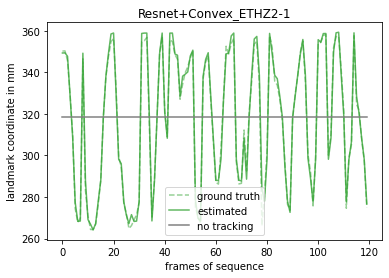

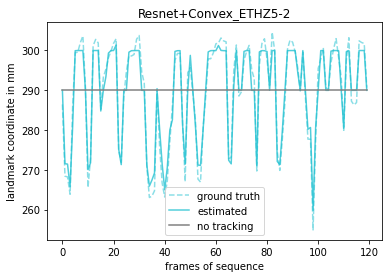

In [13]:
print(disp_coord0.shape)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

lims = torch.zeros(10,2); lims[2] = torch.tensor([203,217]); 
lims[9] = torch.tensor([176,189]);

method = 'Convex'
print(colors)
for i in (2,9):
    title = 'Resnet+'+method+'_ETHZ'+str(int(i//2+1))+'-'+str(int(i%2+1))
    plt.title(title)
    plt.plot(disp_coord0[i,:,0,1],'--',color=colors[i],alpha=.5,label='ground truth')
    plt.plot(disp_coord0[i,:,2,1],'-',color=colors[i],alpha=.75,label='estimated')
    plt.plot(disp_coord0[i,:,1,1],'-',color='gray',label='no tracking')
    plt.xlabel('frames of sequence')
    plt.ylabel('landmark coordinate in mm')
    plt.legend()
    plt.show()
